In [24]:
import pandas as pd
import numpy as np
import pickle
import re
import torch
from torch import nn
import torch.nn.functional as F
# import locale
# locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')

In [25]:
# check if GPU is available
train_on_gpu = torch.cuda.is_available()
if(train_on_gpu):
    print('Training on GPU!')
else: 
    print('No GPU available, training on CPU; consider making n_epochs very small.')

Training on GPU!


In [26]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/portuguese-poems.csv')
print(df.shape)
df.head()

(15543, 4)


,Author,Title,Content,Views
0,Cecília Meireles,Retrato,"Eu não tinha este rosto de hoje,\r\nAssim calm...",1018431
1,Fernando Pessoa,"Para ser grande, sê inteiro: nada","Para ser grande, sê inteiro: nada\r\nTeu exage...",1979413
2,Marina Colasanti,"Eu sei, mas não devia",Eu sei que a gente se acostuma. Mas não devia....,301509
3,Carlos Drummond de Andrade,Quadrilha,João amava Teresa que amava Raimundo\r\nque am...,1421206
4,Eugénio de Andrade,É urgente o amor,É urgente o amor.\r\nÉ urgente um barco no mar...,621197


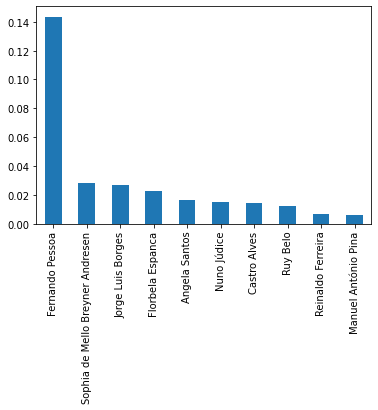

In [27]:
df.Author.value_counts(normalize=True)[:10].plot.bar()

In [28]:
print('Contents vazios')
print(df[df['Content'].isnull()].shape[0])
print()
df = df[df['Content'].notnull()]
print('Content vazio')
print(df[df['Content'].isnull()].shape[0])

Contents vazios
2

Content vazio
0


In [29]:
#df = df.sample(300)

In [30]:
df = df.copy()
df['Content'] = df['Content'].str.replace('\s',' ' )
df.head()

,Author,Title,Content,Views
0,Cecília Meireles,Retrato,"Eu não tinha este rosto de hoje, Assim calmo,...",1018431
1,Fernando Pessoa,"Para ser grande, sê inteiro: nada","Para ser grande, sê inteiro: nada Teu exagera...",1979413
2,Marina Colasanti,"Eu sei, mas não devia",Eu sei que a gente se acostuma. Mas não devia....,301509
3,Carlos Drummond de Andrade,Quadrilha,João amava Teresa que amava Raimundo que amav...,1421206
4,Eugénio de Andrade,É urgente o amor,É urgente o amor. É urgente um barco no mar. ...,621197


In [31]:
dfCoontent = df[['Content']]
dfCoontent.to_csv('/content/drive/My Drive/Colab Notebooks/content.txt',header=None, index=None, sep=' ', mode='a')

In [32]:
# open text file and read in data as `text`
with open('/content/drive/My Drive/Colab Notebooks/content.txt', 'r') as f:
    text = f.read()

In [33]:
text =  text.replace('"','')
text = re.sub(' +',' ',text)
text = re.sub('\n',' ',text)
text[0:200]

'Uma certa quantidade de gente à procura de gente à procura duma certa quantidade Soma: uma paisagem extremamente à procura o problema da luz (adrede ligado ao problema da vergonha) e o problema do qua'

In [34]:


# encode the text and map each character to an integer and vice versa

# we create two dictionaries:
# 1. int2char, which maps integers to characters
# 2. char2int, which maps characters to unique integers

chars = tuple(set(text))
int2char = dict(enumerate(chars))
char2int = {ch: ii for ii, ch in int2char.items()}

# encode the text
encoded = np.array([char2int[ch] for ch in text])

In [35]:


def one_hot_encode(arr, n_labels):
    
    # Initialize the the encoded array
    one_hot = np.zeros((arr.size, n_labels), dtype=np.float32)
    
    # Fill the appropriate elements with ones
    one_hot[np.arange(one_hot.shape[0]), arr.flatten()] = 1.
    
    # Finally reshape it to get back to the original array
    one_hot = one_hot.reshape((*arr.shape, n_labels))
    
    return one_hot

In [36]:
# check that the function works as expected
test_seq = np.array([[0, 5, 1]])
one_hot = one_hot_encode(test_seq, 8)

print(one_hot)

[[[1. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 1. 0. 0.]
  [0. 1. 0. 0. 0. 0. 0. 0.]]]


In [37]:
def get_batches(arr, batch_size, seq_length):
    '''Create a generator that returns batches of size
       batch_size x seq_length from arr.
       
       Arguments
       ---------
       arr: Array you want to make batches from
       batch_size: Batch size, the number of sequences per batch
       seq_length: Number of encoded chars in a sequence
    '''
    
    batch_size_total = batch_size * seq_length
    # total number of batches we can make
    n_batches = len(arr)//batch_size_total
    
    # Keep only enough characters to make full batches
    arr = arr[:n_batches * batch_size_total]
    # Reshape into batch_size rows
    arr = arr.reshape((batch_size, -1))
    
    # iterate through the array, one sequence at a time
    for n in range(0, arr.shape[1], seq_length):
        # The features
        x = arr[:, n:n+seq_length]
        # The targets, shifted by one
        y = np.zeros_like(x)
        try:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, n+seq_length]
        except IndexError:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, 0]
        yield x, y

In [38]:
class CharRNN(nn.Module):
        
        def __init__(self, tokens, n_hidden=256, n_layers=2,
                                   drop_prob=0.5, lr=0.001):
            super().__init__()
            self.drop_prob = drop_prob
            self.n_layers = n_layers
            self.n_hidden = n_hidden
            self.lr = lr
            
            # creating character dictionaries
            self.chars = tokens
            self.int2char = dict(enumerate(self.chars))
            self.char2int = {ch: ii for ii, ch in self.int2char.items()}
            
            #lstm layer
            self.lstm=nn.LSTM(len(self.chars),n_hidden,n_layers,
                              dropout=drop_prob,batch_first=True)
            
            #dropout layer
            self.dropout=nn.Dropout(drop_prob)
            
            #output layer
            self.fc=nn.Linear(n_hidden,len(self.chars))
    
        
        def forward(self, x, hidden):
            ''' Forward pass through the network. 
                These inputs are x, and the hidden/cell state `hidden`. '''
            ## Get the outputs and the new hidden state from the lstm
            r_output, hidden = self.lstm(x, hidden)
            
            ## pass through a dropout layer
            out = self.dropout(r_output)
            
            # Stack up LSTM outputs using view
            # you may need to use contiguous to reshape the output
            out = out.contiguous().view(-1, self.n_hidden)
            
            ## put x through the fully-connected layer
            out = self.fc(out)
            return out, hidden
        
        
        def init_hidden(self, batch_size):
            ''' Initializes hidden state '''
            # Create two new tensors with sizes n_layers x batch_size x n_hidden,
            # initialized to zero, for hidden state and cell state of LSTM
            weight = next(self.parameters()).data
            
            if (train_on_gpu):
                hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda(),
                      weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda())
            else:
                hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_(),
                          weight.new(self.n_layers, batch_size, self.n_hidden).zero_())
            
            return hidden


In [39]:
def train(net, data, epochs=10, batch_size=10, seq_length=50, lr=0.001, clip=5, val_frac=0.1, print_every=1000):
        ''' Training a network 
        
            Arguments
            ---------
            
            net: CharRNN network
            data: text data to train the network
            epochs: Number of epochs to train
            batch_size: Number of mini-sequences per mini-batch, aka batch size
            seq_length: Number of character steps per mini-batch
            lr: learning rate
            clip: gradient clipping
            val_frac: Fraction of data to hold out for validation
            print_every: Number of steps for printing training and validation loss
        
        '''
        net.train()
        
        opt = torch.optim.Adam(net.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()
        
        # create training and validation data
        val_idx = int(len(data)*(1-val_frac))
        data, val_data = data[:val_idx], data[val_idx:]
        
        if(train_on_gpu):
            net.cuda()
        
        counter = 0
        n_chars = len(net.chars)
        for e in range(epochs):
            # initialize hidden state
            h = net.init_hidden(batch_size)
            
            for x, y in get_batches(data, batch_size, seq_length):
                counter += 1
                
                # One-hot encode our data and make them Torch tensors
                x = one_hot_encode(x, n_chars)
                inputs, targets = torch.from_numpy(x), torch.from_numpy(y)
                
                if(train_on_gpu):
                    inputs, targets = inputs.cuda(), targets.cuda()
    
                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history
                h = tuple([each.data for each in h])
    
                # zero accumulated gradients
                net.zero_grad()
                
                # get the output from the model
                output, h = net(inputs, h)
                
                # calculate the loss and perform backprop
                loss = criterion(output, targets.view(batch_size*seq_length).long())
                loss.backward()
                # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
                nn.utils.clip_grad_norm_(net.parameters(), clip)
                opt.step()
                
                # loss stats
                if counter % print_every == 0:
                    # Get validation losstrain_model
                    val_h = net.init_hidden(batch_size)
                    val_losses = []
                    net.eval()
                    for x, y in get_batches(val_data, batch_size, seq_length):
                        # One-hot encode our data and make them Torch tensors
                        x = one_hot_encode(x, n_chars)
                        x, y = torch.from_numpy(x), torch.from_numpy(y)
                        
                        # Creating new variables for the hidden state, otherwise
                        # we'd backprop through the entire training history
                        val_h = tuple([each.data for each in val_h])
                        
                        inputs, targets = x, y
                        if(train_on_gpu):
                            inputs, targets = inputs.cuda(), targets.cuda()
    
                        output, val_h = net(inputs, val_h)
                        val_loss = criterion(output, targets.view(batch_size*seq_length).long())
                    
                        val_losses.append(val_loss.item())
                    
                    net.train() # reset to train mode after iterationg through validation data
                    
                    print("Epoch: {}/{}...".format(e+1, epochs),
                          "Step: {}...".format(counter),
                          "Loss: {:.4f}...".format(loss.item()),
                          "Val Loss: {:.4f}".format(np.mean(val_losses)))

In [71]:
## define and print the net
n_hidden = 512
n_layers = 2

net = CharRNN(chars, n_hidden, n_layers)
print(net)

CharRNN(
  (lstm): LSTM(176, 512, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=512, out_features=176, bias=True)
)


In [ ]:
batch_size = 128
seq_length = 100

train(net, encoded, epochs=10, batch_size=batch_size, seq_length=seq_length, lr=0.001, print_every=1000)

Epoch: 1/10... Step: 1000... Loss: 2.0460... Val Loss: 2.0354
Epoch: 1/10... Step: 2000... Loss: 1.8264... Val Loss: 1.7554
Epoch: 1/10... Step: 3000... Loss: 1.6588... Val Loss: 1.6266
Epoch: 1/10... Step: 4000... Loss: 1.5721... Val Loss: 1.5593
Epoch: 2/10... Step: 5000... Loss: 1.5643... Val Loss: 1.5159
Epoch: 2/10... Step: 6000... Loss: 1.5444... Val Loss: 1.4868
Epoch: 2/10... Step: 7000... Loss: 1.5380... Val Loss: 1.4669
Epoch: 2/10... Step: 8000... Loss: 1.5074... Val Loss: 1.4502
Epoch: 3/10... Step: 9000... Loss: 1.4790... Val Loss: 1.4340
Epoch: 3/10... Step: 10000... Loss: 1.4776... Val Loss: 1.4243
Epoch: 3/10... Step: 11000... Loss: 1.5075... Val Loss: 1.4166
Epoch: 3/10... Step: 12000... Loss: 1.4722... Val Loss: 1.4082
Epoch: 4/10... Step: 13000... Loss: 1.4265... Val Loss: 1.4000
Epoch: 4/10... Step: 14000... Loss: 1.4354... Val Loss: 1.3938
Epoch: 4/10... Step: 15000... Loss: 1.4279... Val Loss: 1.3906
Epoch: 4/10... Step: 16000... Loss: 1.4398... Val Loss: 1.3847
E

In [42]:
def predict(net, char, h=None, top_k=None):
        ''' Given a character, predict the next character.
            Returns the predicted character and the hidden state.
        '''
        
        # tensor inputs
        x = np.array([[net.char2int[char]]])
        x = one_hot_encode(x, len(net.chars))
        inputs = torch.from_numpy(x)
        
        if(train_on_gpu):
            inputs = inputs.cuda()
        
        # detach hidden state from history
        h = tuple([each.data for each in h])
        # get the output of the model
        out, h = net(inputs, h)

        # get the character probabilities
        p = F.softmax(out, dim=1).data
        if(train_on_gpu):
            p = p.cpu() # move to cpu
        
        # get top characters
        if top_k is None:
            top_ch = np.arange(len(net.chars))
        else:
            p, top_ch = p.topk(top_k)
            top_ch = top_ch.numpy().squeeze()
        
        # select the likely next character with some element of randomness
        p = p.numpy().squeeze()
        char = np.random.choice(top_ch, p=p/p.sum())
        
        # return the encoded value of the predicted char and the hidden state
        return net.int2char[char], h

In [61]:
def sample(net, size, prime='você', top_k=None):
        
    if(train_on_gpu):
        net.cuda()
    else:
        net.cpu()
    
    net.eval() # eval mode
    
    # First off, run through the prime characters
    chars = [ch for ch in prime]
    h = net.init_hidden(1)
    for ch in prime:
        char, h = predict(net, ch, h, top_k=top_k)

    chars.append(char)
    
    # Now pass in the previous character and get a new one
    for ii in range(size):
        char, h = predict(net, chars[-1], h, top_k=top_k)
        chars.append(char)

    return ''.join(chars)

In [67]:
poema = sample(net, 200, prime='amor', top_k=2)
poema

'amor, este prazer de amar e de conta de mim, e a minha alma é a minha alegria....  A mentira do coração é a mesma esperança. A mesa está provoco o meu passado em todas as coisas. A casa é uma canção de sen'

In [63]:
poema = sample(net, 200, prime='amor', top_k=20)
poema

'amor. O caso, mesmo há humanas chorando, chovem e bronzenados de claro cegodepois de emergirtantes do desejo.Abrindo-me à hora, os prestádiospobreráviques eixes, franzes.Mas sei aos murmúrios dos dias,os p'

In [65]:
poema = sample(net, 200, prime='amor', top_k=100)
poema

'amor; se um madulo se lireia onde cãos-dia, como ora universal apenas expressa da escravidão e o nosso bambe se passa um tiráculo daquela dor; e se ao pescar-lhe morro, tanta paixão de Primavera. Mas me pe'